# McCall job-search model

## Setting the scene

The McCall job-search model is extened to allow for heterogenous workers, endogenous search-effort and time dependent UI-benefit.

Two UI-benefit policies are implemented:


*   **Policy 1**: Current structure in Denmark with UI-benefits up to 2 years (104 weeks) after unemployment.
*   **Policy 2**: New proposal with UI-benefits up to 1 year (52 weeks) after unemployment

Workers differ in their skill-level:


*   **High-skilled**: Lower cost of search, higher expected wage-offers and higher benefit-level.
*   **Low-skilled**: Higher cost of search, lower expected wage-offers and lower benefit-level.

# Packages

In [61]:
## Loading packages used throughout the code

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy.integrate import quad
from scipy.optimize import fsolve
from matplotlib.lines import Line2D

#Income data and wage distributions - calibrated to Danish data

In [62]:
## Incomce deciles for Danish income from Denmarks Statistics (see source in the paper)
deciles = np.array([
    96295, 176981, 208472, 238441, 269697,
    301829, 337862, 383209, 452178, 834074
])

## Taking log of the deciles
ln_income = np.log(deciles)

## Calculating mu and sigma for the data-implied log-normal distribution
mu = np.mean(ln_income)
sigma = np.std(ln_income) * np.sqrt((len(ln_income) - 1) / len(ln_income))  # MLE correction

## Re-fitting the distribution to match a wage interval of [0,20]
z99 = norm.ppf(0.99) #Computing 99th percentile of the std. normal distribution
p99 = np.exp(mu + sigma * z99) #Computing the 99th percentile of the log-normal distribution
s = p99 / 20 #Calculating the scale factor needed to shift the 99th percentile down to 20

# Adjusting mu with the scaling parameter - the shape parameter remains the same
mu_model = mu - np.log(s)
sigma_model = sigma

## Print parameter estimates
print(f"μ (high-skilled)     = {mu_model:.4f}")
print(f"μ (low-skilled)     = {0.9*mu_model:.4f}")
print(f"σ (model-scale)     = {sigma_model:.4f}")

## Median-disponible income in Denmark - from Denmarks Statistics (see sources in the paper)
median_disp_yearly = 269697

# Disponible income first three months of UI (highest rate)
first_three = 17126 # Maximum benefit less taxes and labour-market contribution (per month)
afterwards = 14660 # Eligible benefit after three months less taxes and labour-market contribution (per month)

# Finding the share that UI-benefits replace of a median workers annual disposable income
share = (first_three * 3 + afterwards * 21)/ (median_disp_yearly*2)
print(f"UI-benefit share of disposable income (median worker): {share}")

# Model-implied benefit payment each month
scale = s
benefit_payment = share * median_disp_yearly * 1/scale
print(f"UI-benefit at the start of the model: {benefit_payment}")

μ (high-skilled)     = 1.7823
μ (low-skilled)     = 1.6041
σ (model-scale)     = 0.5216
UI-benefit share of disposable income (median worker): 0.6660029588760721
UI-benefit at the start of the model: 3.764252361947038


## Plots of wage-distributions - Figure 1

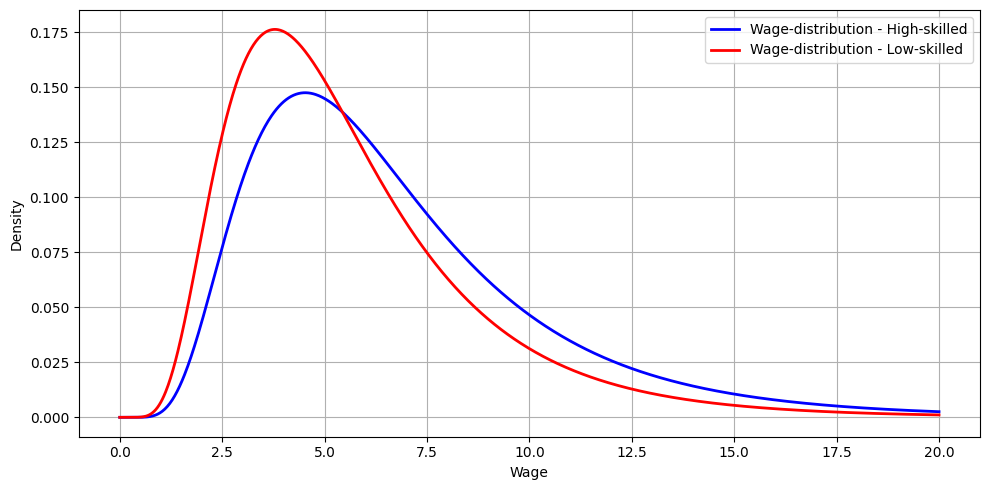

In [63]:
## Plot model-implied wage distributions
x_vals = np.linspace(0.001, 20, 1000)
pdf_vals_high = (1 / (x_vals * sigma_model * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x_vals) - mu_model) ** 2) / (2 * sigma_model ** 2))
pdf_vals_low = (1 / (x_vals * sigma_model * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x_vals) - mu_model*0.9) ** 2) / (2 * sigma_model ** 2))
plt.figure(figsize=(10, 5))
plt.plot(x_vals, pdf_vals_high, 'b-', linewidth=2, label='Wage-distribution - High-skilled')
plt.plot(x_vals, pdf_vals_low, 'r-', linewidth=2, label='Wage-distribution - Low-skilled')
plt.xlabel("Wage")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Parameterization and functions


In [64]:
# General parameters
T = 200
beta = 0.999014 # Weekly discount - see paper
gamma = 1.5 # Cost-function shape parameter
eta = 0.5 # CRRA-utility parameter
w_min, w_max = 0.0, 20.0 # Wage-interval
sigma = sigma_model # Parameter for the wage-distributions


# Recall from the paper, that high-skilled and low-skilled workers vary by their cost of effort and
# wage-distributions --> higher expected wage-offer for high-skilled and lower search costs.

# High-skilled workers
k_high = 4 # Cost-function scale parameter
mu_high = mu_model # Wage-distribution parameter
b_value_high = benefit_payment # UI-benefit
dist_high = lognorm(s=sigma, scale=np.exp(mu_high)) # Wage-distribution

# Low-skilled workers
k_low = 8 # Cost-function scale parameter
mu_low = 0.9 * mu_model # Wage-distribution parameter
b_value_low = 0.9 * benefit_payment # UI-benefit
dist_low = lognorm(s=sigma, scale=np.exp(mu_low)) # Wage-distribution

# Flow utility of consumption when employed
def value(w):
    return np.log(w)

# Flow utility of consumption when unemployed
def U(b):
    return (b**(1-eta)-1)/(1-eta)

# Function to calculate the integral in Equation (10) and (11)
def EX_value_above_R_lognorm(dist,w):
    integrand = lambda x: (np.log(x) - np.log(w)) * dist.pdf(x) if x > 0 else 0.0
    return quad(integrand, w, w_max)[0] / dist.cdf(w_max) # Scaling values to account for probability mass in the tale > 20

# Function to calculate the expected reemployment wage (Page 9)
def reemp_wage(dist, w):
    integrand = lambda x: x * dist.pdf(x) if x > 0 else 0.0
    return quad(integrand, w, w_max)[0] / (dist.cdf(w_max) - dist.cdf(w))

# Search production function - linear in effort
def p(e):
    return e

# Cost function
def c(e, k):
    return k * (e**(1+gamma))/(1+gamma)

# Composite of actual cost of effort and the inverse of the search production function
def c_tilde(e, k):
    return k * (e**(1+gamma))/(1+gamma)

# Derivate and inverse of composite-cost-functio - used in Equation (10)
def c_tilde_dif_inverse(x, k):
    return (x / k) ** (1/gamma)

## Plots to compare utility-functions and cost-functions - Figure 3 and 4

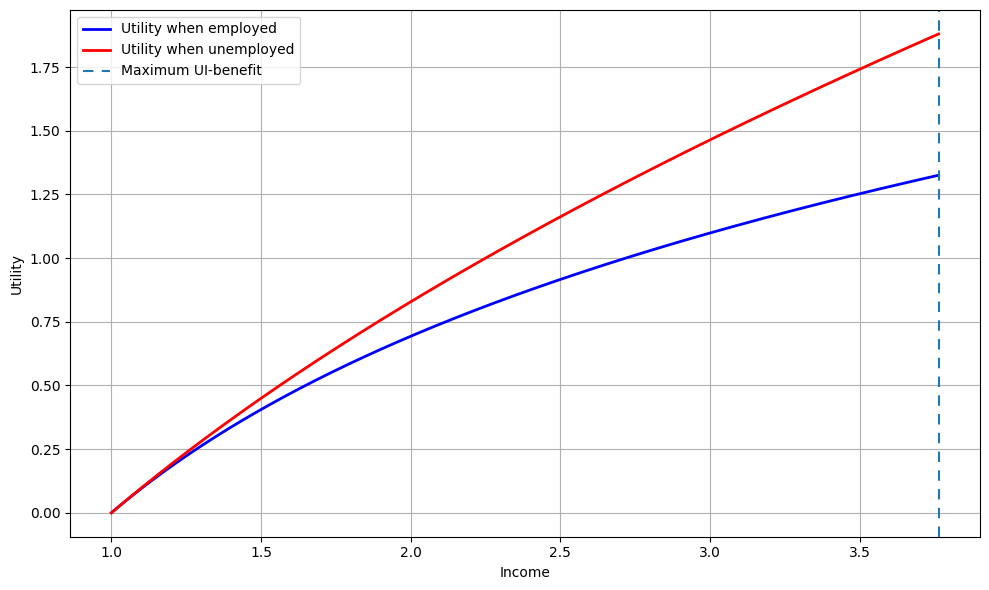

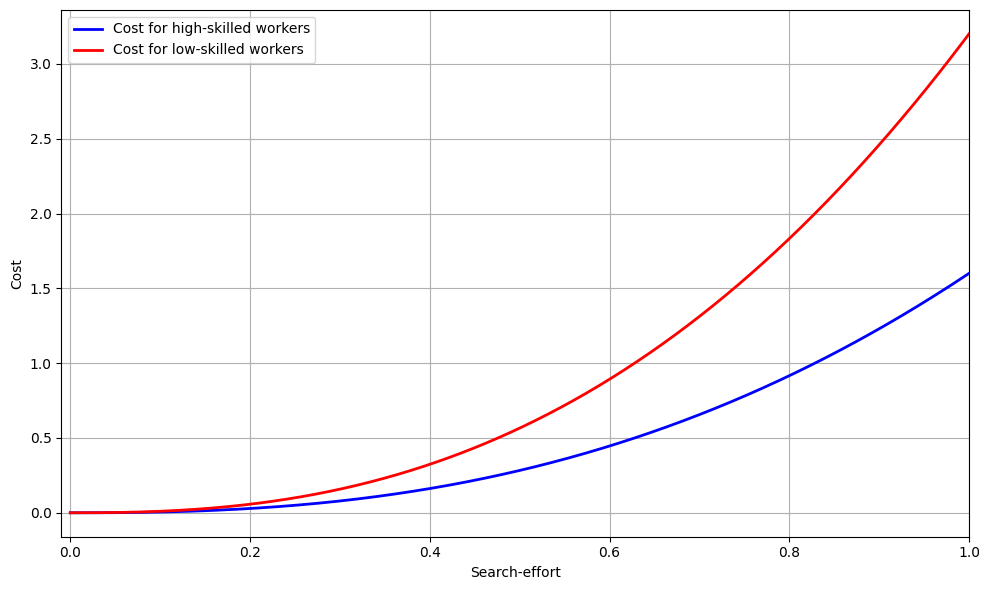

In [65]:
# Comparing utility functions for employed and unemployed workers
x = np.linspace(1.0, b_value_high, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x, value(x), label="Utility when employed", color='blue', linewidth=2)
plt.plot(x, U(x), label="Utility when unemployed", color='red', linewidth=2)
plt.xlabel("Income")
plt.ylabel("Utility")
plt.axvline(x = b_value_high, label = "Maximum UI-benefit", dashes=[5, 4])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Comparing cost-functions between high-skilled and low-skilled workers
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x, c(x,k_high), label="Cost for high-skilled workers", color='blue', linewidth=2)
plt.plot(x, c(x, k_low), label="Cost for low-skilled workers", color='red', linewidth=2)
plt.xlabel("Search-effort")
plt.ylabel("Cost")
plt.xlim(-0.01,1.00)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Steady-state values

In [66]:
# Finding starting value for reservation-wage - Equation (12) and (13)
def steady_state(var, b_value, k, dist):
    w_ss, e_ss = var

    Eq10 = e_ss - c_tilde_dif_inverse(beta / (1 - beta) * EX_value_above_R_lognorm(dist,w_ss), k)

    Eq11 = value(w_ss) - (U(b_value) - c_tilde(e_ss, k)) - beta / (1-beta) * p(e_ss) * EX_value_above_R_lognorm(dist, w_ss)

    return [Eq10, Eq11]

# Initial guess
w0 = 7.0
e0 = 0.5

# For constant benefit b = 2.0 - kontanthjælp
w_ss_high = fsolve(lambda var: steady_state(var, b_value=2.0, k = k_high, dist = dist_high), [w0, e0])[0]
w_ss_low = fsolve(lambda var: steady_state(var, b_value=2.0, k = k_low, dist = dist_low), [w0, e0])[0]

print(w_ss_high)
print(w_ss_low)

14.954933676299515
13.070004810907491


# UI-policies

In [67]:
# Helper function
def UI_policy(b_value, T):
    return lambda t: b_value if t <= T else 2.0

# UI-policy for high-skilled workers
policies_high = {
    'UI - 104 weeks': UI_policy(b_value_high, 104),
    'UI - 52 weeks': UI_policy(b_value_high, 52),
}

# UI-policy for low-skilled workers
policies_low = {
    'UI - 104 weeks': UI_policy(b_value_low, 104),
    'UI - 52 weeks': UI_policy(b_value_low, 52),
}

## Plotting UI-policies for each worker - Figure 2

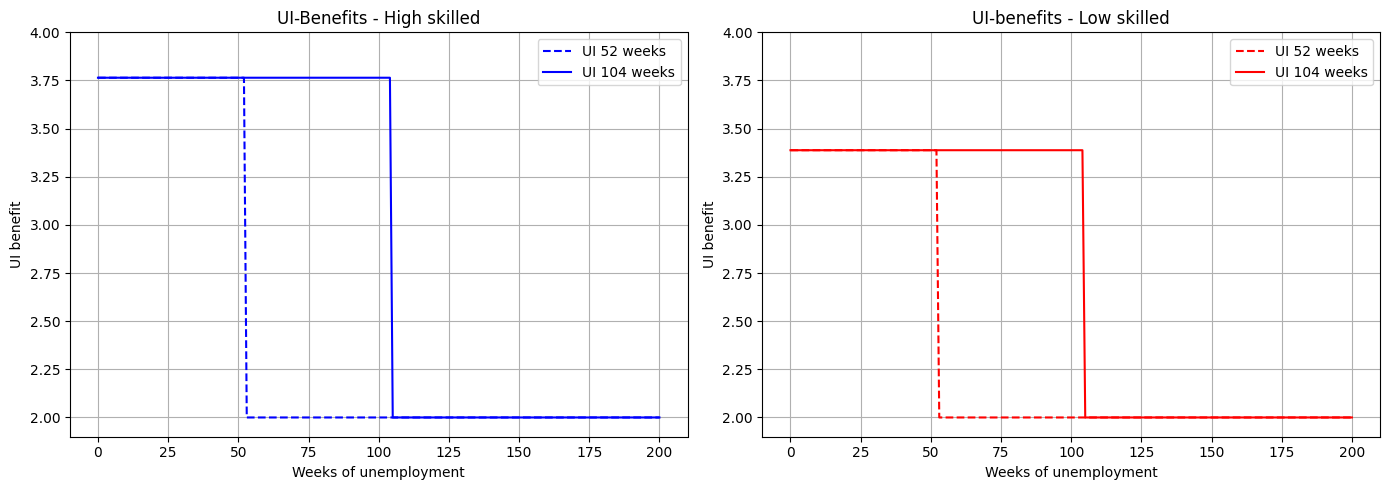

In [68]:
weeks = range(201)  # Weeks 0–200
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: High skilled workers
ax = axs[0]
ax.plot([policies_high['UI - 52 weeks'](t) for t in weeks],
        '--', label='UI 52 weeks', color = "blue")
ax.plot([policies_high['UI - 104 weeks'](t) for t in weeks],
        '-',  label='UI 104 weeks', color = "blue")
ax.set_title('UI-Benefits - High skilled')
ax.set_xlabel('Weeks of unemployment')
ax.set_ylabel('UI benefit')
ax.legend(loc='upper right')
ax.set_ylim(1.9, 4)
ax.grid(True)

# Right panel: Low skilled workers
ax = axs[1]
ax.plot([policies_low['UI - 52 weeks'](t) for t in weeks],
        '--', label='UI 52 weeks', color = "red")
ax.plot([policies_low['UI - 104 weeks'](t) for t in weeks],
        '-',  label='UI 104 weeks', color = "red")
ax.set_title('UI-benefits - Low skilled')
ax.set_xlabel('Weeks of unemployment')
ax.set_ylabel('UI benefit')
ax.legend(loc='upper right')
ax.grid(True)
ax.set_ylim(1.9, 4)
plt.tight_layout()
plt.show()

# The McCall job-search model

## High-skilled workers

In [69]:
 # Creating dictionaries to store results
reservation_wage_high = {}
optimal_effort_high = {}
value_unemployment_high = {}
reempl_wage_high = {}

# Solve for each policy
for UI_policy, UI_scheme in policies_high.items():
    w = np.zeros(T+2)
    e_star = np.zeros(T+1)
    V_U = np.zeros(T+1)
    re_w = np.zeros(T+1)

    w[T+1] = w_ss_high # Initialize reservation wage at the SS-value

    for t in reversed(range(T+1)):
        b_t = UI_scheme(t) # Extracting benefit scheme for high-skilled workers

        # Search-effort
        e = c_tilde_dif_inverse((beta/(1-beta)) * EX_value_above_R_lognorm(dist_high, w[t+1]), k_high)
        e_star[t] = np.clip(e, 0, 1)

        # Reservation wage
        w[t] = np.exp((1-beta) * (U(b_t) - c_tilde(e_star[t], k_high)) + beta * value(w[t+1]) + beta * (p(e_star[t]) * EX_value_above_R_lognorm(dist_high, w[t+1])))

        # Value of unemployment
        V_U[t] = np.log(w[t]) / (1-beta)

        # Expected reemployment wage
        re_w[t] = reemp_wage(dist_high, w[t])

    reservation_wage_high[UI_policy] = w
    optimal_effort_high[UI_policy] = e_star
    value_unemployment_high[UI_policy] = V_U
    reempl_wage_high[UI_policy] = re_w

##Low-skilled workers

In [70]:
# Solving the McCall-model for all policies

reservation_wage_low = {}
optimal_effort_low = {}
value_unemployment_low = {}
reempl_wage_low = {}

# Solve for each policy - low-skilled
for UI_policy, UI_scheme in policies_low.items():
    w = np.zeros(T+2)
    e_star = np.zeros(T+1)
    V_U = np.zeros(T+1)
    re_w = np.zeros(T+1)

    w[T+1] = w_ss_low

    for t in reversed(range(T+1)):
        b_t = UI_scheme(t) # Extracting benefit scheme for low-skilled worker

        # Search-effort
        e = c_tilde_dif_inverse((beta/(1-beta))* EX_value_above_R_lognorm(dist_low, w[t+1]),k_low)
        e_star[t] = np.clip(e, 0, 1)

        # Reservation wage
        w[t] = np.exp((1-beta) * (U(b_t) - c_tilde(e_star[t], k_low)) + beta * value(w[t+1]) + beta * (p(e_star[t]) * EX_value_above_R_lognorm(dist_low, w[t+1])))

        # Value of unemployment
        V_U[t] = np.log(w[t]) / (1-beta)

        # Expected reemployment wage
        re_w[t] = reemp_wage(dist_low, w[t])

    reservation_wage_low[UI_policy] = w
    optimal_effort_low[UI_policy] = e_star
    value_unemployment_low[UI_policy] = V_U
    reempl_wage_low[UI_policy] = re_w


# Empirical moments

## Hazard function, survival function and share of unemployed

In [71]:
# Hazard function - Section 3.3
Hazard_UI52_high = optimal_effort_high["UI - 52 weeks"]* (1-dist_high.cdf(reservation_wage_high["UI - 52 weeks"][1:]))
Hazard_UI104_high = optimal_effort_high["UI - 104 weeks"]* (1-dist_high.cdf(reservation_wage_high["UI - 104 weeks"][1:]))
Hazard_UI52_low = optimal_effort_low["UI - 52 weeks"]* (1-dist_low.cdf(reservation_wage_low["UI - 52 weeks"][1:]))
Hazard_UI104_low = optimal_effort_low["UI - 104 weeks"]* (1-dist_low.cdf(reservation_wage_low["UI - 104 weeks"][1:]))

# Survival function - Section 3.3
Survival_UI52_high = np.concatenate([[1], np.cumprod(1 - Hazard_UI52_high)])
Survival_UI104_high = np.concatenate([[1], np.cumprod(1 - Hazard_UI104_high)])
Survival_UI52_low = np.concatenate([[1], np.cumprod(1 - Hazard_UI52_low)])
Survival_UI104_low = np.concatenate([[1], np.cumprod(1 - Hazard_UI104_low)])

# Share of unemployed workers - Section 3.3
total_high_UI52 = Survival_UI52_high / (Survival_UI52_high + Survival_UI52_low)
total_low_UI52 = Survival_UI52_low / (Survival_UI52_high + Survival_UI52_low)
total_high_UI104 = Survival_UI104_high / (Survival_UI104_high + Survival_UI104_low)
total_low_UI104 = Survival_UI104_low / (Survival_UI104_high + Survival_UI104_low)

## Aggregate reemployment wage

In [72]:
# Entry‐shares and list of both UI-policies
p = 0.5
policies = ["UI - 52 weeks", "UI - 104 weeks"]

# Survival and hazard dictionaries
S_high = {
    "UI - 52 weeks": Survival_UI52_high,
    "UI - 104 weeks": Survival_UI104_high,
}
S_low = {
    "UI - 52 weeks": Survival_UI52_low,
    "UI - 104 weeks": Survival_UI104_low,
}
h_high = {
    "UI - 52 weeks": Hazard_UI52_high,
    "UI - 104 weeks": Hazard_UI104_high,
}
h_low = {
    "UI - 52 weeks": Hazard_UI52_low,
    "UI - 104 weeks": Hazard_UI104_low,
}

# Compute aggregate reemployment wage for each policy - Section 3.4
agg_reemp = {}
for policy in policies:
    SH = S_high[policy][:201]
    SL = S_low[policy][:201]
    hH = h_high[policy][:201]
    hL = h_low[policy][:201]
    wH = reempl_wage_high[policy][:201]
    wL = reempl_wage_low[policy][:201]

    agg_reemp[policy] = (wH * hH * SH * p + wL * hL * SL * p) / (hH * SH * p + hL * SL * p)

## Expected unemployment duration and %-change - Table 1

In [73]:
# Expected unemployment duration
print(sum(Survival_UI104_high))
print(sum(Survival_UI52_high))
print(sum(Survival_UI104_low))
print(sum(Survival_UI52_low))

# Percentage change
print((sum(Survival_UI52_high)-sum(Survival_UI104_high))/sum(Survival_UI104_high))
print((sum(Survival_UI52_low)-sum(Survival_UI104_low))/sum(Survival_UI104_low))

40.127896727240866
34.24272512859963
58.22552974650604
51.365777639047316
-0.1466603554789873
-0.11781347696317629


# Plots

## Legends

In [74]:
# For plots - legends
handles1 = [
    Line2D([], [], color='red',   label='Low skilled'),
    Line2D([], [], color='blue',  label='High skilled'),
    Line2D([], [], color='none',  label=''),            # spacer
    Line2D([], [], color='black', linestyle='--', label='UI for 1 year'),
    Line2D([], [], color='black', linestyle='-',  label='UI for 2 years'),
    Line2D([], [], color='grey', linestyle='--', label='UI cutoffs'),
]

handles2 = [
    Line2D([], [], color='black', linestyle='--', label='UI for 1 year'),
    Line2D([], [], color='black', linestyle='-', label='UI for 2 years' ),
]

## Simulations of the McCall-model - Figure 5

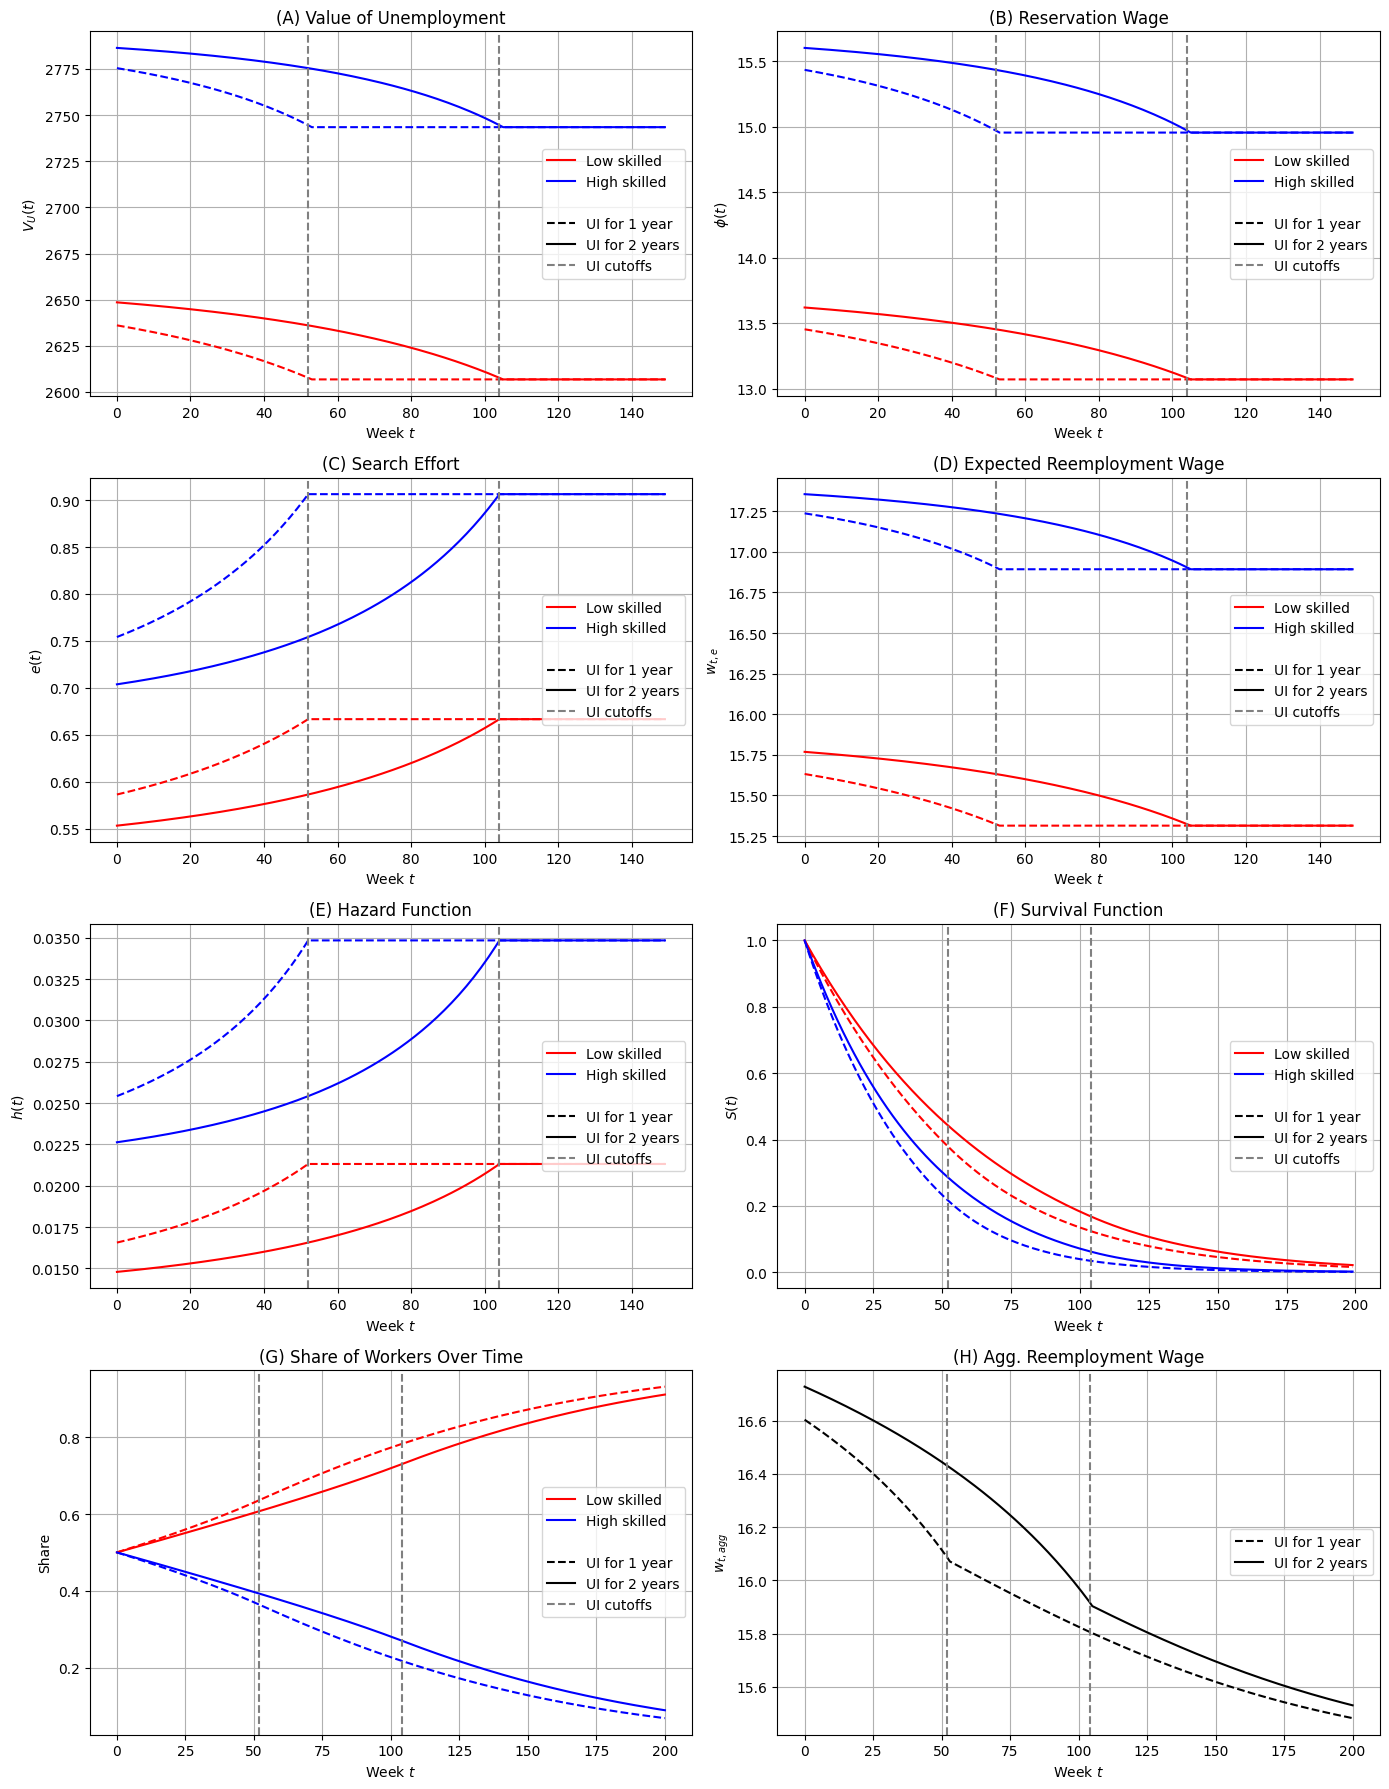

In [75]:
# Create 4×2 grid once
fig, axes = plt.subplots(4, 2, figsize=(14, 18))
axes = axes.flatten()

# A) Value of unemployment
ax = axes[0]
ax.plot(value_unemployment_low ["UI - 52 weeks"][0:150],  color='red',  linestyle='--')
ax.plot(value_unemployment_high["UI - 52 weeks"][0:150],  color='blue', linestyle='--')
ax.plot(value_unemployment_low ["UI - 104 weeks"][0:150], color='red',  linestyle='-')
ax.plot(value_unemployment_high["UI - 104 weeks"][0:150], color='blue', linestyle='-')
ax.set_xlabel("Week $t$")
ax.set_ylabel(r"$V_U(t)$")
ax.set_title(r"(A) Value of Unemployment")
ax.axvline(52,  color='grey', linestyle='--')
ax.axvline(104, color='grey', linestyle='--')
ax.grid(True)
ax.legend(handles=handles1, loc='center right')

# B) Reservation wage
ax = axes[1]
ax.plot(reservation_wage_low ["UI - 52 weeks"][0:150],  color='red',  linestyle='--')
ax.plot(reservation_wage_high["UI - 52 weeks"][0:150],  color='blue', linestyle='--')
ax.plot(reservation_wage_low ["UI - 104 weeks"][0:150], color='red',  linestyle='-')
ax.plot(reservation_wage_high["UI - 104 weeks"][0:150], color='blue', linestyle='-')
ax.set_xlabel("Week $t$")
ax.set_ylabel(r"$\phi(t)$")
ax.set_title(r"(B) Reservation Wage")
ax.axvline(52,  color='grey', linestyle='--')
ax.axvline(104, color='grey', linestyle='--')
ax.grid(True)
ax.legend(handles=handles1, loc='center right')

# C) Optimal effort
ax = axes[2]
ax.plot(optimal_effort_low ["UI - 52 weeks"][0:150],  color='red',  linestyle='--')
ax.plot(optimal_effort_high["UI - 52 weeks"][0:150],  color='blue', linestyle='--')
ax.plot(optimal_effort_low ["UI - 104 weeks"][0:150], color='red',  linestyle='-')
ax.plot(optimal_effort_high["UI - 104 weeks"][0:150], color='blue', linestyle='-')
ax.set_xlabel("Week $t$")
ax.set_ylabel(r"$e(t)$")
ax.set_title(r"(C) Search Effort")
ax.axvline(52,  color='grey', linestyle='--')
ax.axvline(104, color='grey', linestyle='--')
ax.grid(True)
ax.legend(handles=handles1, loc='center right')

# D) Reemployment wage
ax = axes[3]
ax.plot(reempl_wage_low ["UI - 52 weeks"][0:150],  color='red',  linestyle='--')
ax.plot(reempl_wage_high["UI - 52 weeks"][0:150],  color='blue', linestyle='--')
ax.plot(reempl_wage_low ["UI - 104 weeks"][0:150], color='red',  linestyle='-')
ax.plot(reempl_wage_high["UI - 104 weeks"][0:150], color='blue', linestyle='-')
ax.set_xlabel("Week $t$")
ax.set_ylabel(r"$w_{t,e}$")
ax.set_title(r"(D) Expected Reemployment Wage")
ax.axvline(52,  color='grey', linestyle='--')
ax.axvline(104, color='grey', linestyle='--')
ax.grid(True)
ax.legend(handles=handles1, loc='center right')

# E) Hazard rate
ax = axes[4]
ax.plot(Hazard_UI52_low [0:150],  color='red',  linestyle='--')
ax.plot(Hazard_UI52_high[0:150],  color='blue', linestyle='--')
ax.plot(Hazard_UI104_low[0:150],  color='red',  linestyle='-')
ax.plot(Hazard_UI104_high[0:150], color='blue', linestyle='-')
ax.set_xlabel("Week $t$")
ax.set_ylabel(r"$h(t)$")
ax.set_title(r"(E) Hazard Function")
ax.axvline(52,  color='grey', linestyle='--')
ax.axvline(104, color='grey', linestyle='--')
ax.grid(True)
ax.legend(handles=handles1, loc='center right')

# F) Survival function
ax = axes[5]
ax.plot(Survival_UI52_low [0:200],  color='red',  linestyle='--')
ax.plot(Survival_UI52_high[0:200],  color='blue', linestyle='--')
ax.plot(Survival_UI104_low[0:200],  color='red',  linestyle='-')
ax.plot(Survival_UI104_high[0:200], color='blue', linestyle='-')
ax.set_xlabel("Week $t$")
ax.set_ylabel(r"$S(t)$")
ax.set_title(r"(F) Survival Function")
ax.axvline(52,  color='grey', linestyle='--')
ax.axvline(104, color='grey', linestyle='--')
ax.grid(True)
ax.legend(handles=handles1, loc='center right')

# G) Share of workers
ax = axes[6]
ax.plot(total_low_UI52 [0:201],  color='red',  linestyle='--')
ax.plot(total_high_UI52[0:201],  color='blue', linestyle='--')
ax.plot(total_low_UI104[0:201],  color='red',  linestyle='-')
ax.plot(total_high_UI104[0:201], color='blue', linestyle='-')
ax.set_xlabel("Week $t$")
ax.set_ylabel("Share")
ax.set_title("(G) Share of Workers Over Time")
ax.axvline(52,  color='grey', linestyle='--')
ax.axvline(104, color='grey', linestyle='--')
ax.grid(True)
ax.legend(handles=handles1, loc='center right')

# H) Agg reemployment wage
ax = axes[7]
ax.plot(agg_reemp["UI - 52 weeks"],  color='black',  linestyle='--')
ax.plot(agg_reemp["UI - 104 weeks"], color='black', linestyle='-')
ax.set_xlabel("Week $t$")
ax.set_ylabel(r"$w_{t,agg}$")
ax.set_title(r"(H) Agg. Reemployment Wage")
ax.axvline(52,  color='grey', linestyle='--')
ax.axvline(104, color='grey', linestyle='--')
ax.grid(True)
ax.legend(handles = handles2, loc = "center right")
plt.tight_layout()
plt.show()